In [2]:
!python minigpt-bigram.py

Number of CUDA devices: 1
Current device ID: 0
Device name: Quadro RTX 5000
Device properties: _CudaDeviceProperties(name='Quadro RTX 5000', major=7, minor=5, total_memory=16117MB, multi_processor_count=48)
Memory allocated: 0
Memory reserved: 0
Using device: cuda
^C
Traceback (most recent call last):
  File "/notebooks/ML-system-design/mingpt/minigpt-bigram.py", line 75, in <module>
    xval, yval = get_batch('val', batch_size=len(val_data))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/notebooks/ML-system-design/mingpt/minigpt-bigram.py", line 71, in get_batch
    x = torch.stack([data[i:i+block_size] for i in ix])
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/notebooks/ML-system-design/mingpt/minigpt-bigram.py", line 71, in <listcomp>
    x = torch.stack([data[i:i+block_size] for i in ix])
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


runs log
- [MLP baseline @ 2195 parameters](https://github.com/SolbiatiAlessandro/ML-system-design/commit/c9685b1e5835a05f84c0592773dc9386268b762c), train loss = 1.45, validation loss = 1.71 
- [Bigram + Adam @ 65 parameters](https://github.com/SolbiatiAlessandro/ML-system-design/commit/2362e2d0ac59be8afdd78ab9db119b33f8ce6f8d),  training loss = 2.49, validation loss = 2.52
- Bigram @ 65 parameters,  training loss = 2.73, validation loss = 2.72
- Random Choice, theoretical loss = 4.17


# Environment

In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-02-17 05:57:19--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2025-02-17 05:57:19 (57.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [1]:
import torch

# 1. Define a device variable. If a GPU is available, use it.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available CUDA devices
    num_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_devices)

    # Get information about the current device
    current_device_id = torch.cuda.current_device()
    print("Current device ID:", current_device_id)

    # Get the name of the current device
    device_name = torch.cuda.get_device_name(current_device_id)
    print("Device name:", device_name)

    # Get detailed device properties
    device_props = torch.cuda.get_device_properties(current_device_id)
    print("Device properties:", device_props)

    # Get memory information
    memory_allocated = torch.cuda.memory_allocated(current_device_id)
    memory_reserved = torch.cuda.memory_reserved(current_device_id)
    print("Memory allocated:", memory_allocated)
    print("Memory reserved:", memory_reserved)
else:
    print("CUDA is not available.")

Using device: cuda
Number of CUDA devices: 1
Current device ID: 0
Device name: Quadro RTX 5000
Device properties: _CudaDeviceProperties(name='Quadro RTX 5000', major=7, minor=5, total_memory=16117MB, multi_processor_count=48)
Memory allocated: 0
Memory reserved: 0


In [192]:
!nvidia-smi

Mon Feb 17 19:28:52 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:00:05.0 Off |                  Off |
| 33%   25C    P8    13W / 230W |   1597MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [366]:
hyperparams = {
    'block_size': 8,
    'embedding_dim': 10,
    'hidden_layer': 10*10*5,
    'batch_size': 128,
    'epochs': 100000
}

# Shakespeare dataset

In [1]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
len(text)

1115394

In [38]:
# other tokenizer can use 
# https://github.com/openai/tiktoken
# https://github.com/google/sentencepiece 

characters = set()
for c in text:
    characters.add(c)
vocab_size = len(characters)
int_to_characters = {i: c for i, c in enumerate(characters)}
characters_to_int = {c: i for i, c in enumerate(characters)}


In [173]:
# could also be done w torch.stack
data = [characters_to_int[c] for c in text]
n = int(0.9 * len(data))
train_data = torch.tensor(data[:n], device=device)
val_data = torch.tensor(data[n:], device=device)

In [174]:
train_data.shape, val_data.shape

(torch.Size([1003854]), torch.Size([111540]))

In [367]:
torch.manual_seed(1337)
batch_size = hyperparams['batch_size']
block_size = hyperparams['block_size']

def get_batch(split , batch_size=batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data) - block_size, (batch_size,), device=device)
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

In [176]:
xb, yb = get_batch('train')
xb.shape, yb.shape

(torch.Size([128, 8]), torch.Size([128, 8]))

In [177]:
xb, yb

(tensor([[49, 58, 60,  ..., 53, 58, 21],
         [42,  6, 29,  ..., 61,  1, 35],
         [51, 38,  1,  ..., 60, 35,  7],
         ...,
         [58, 21, 32,  ..., 61, 35,  1],
         [10, 36, 39,  ..., 47, 38, 15],
         [35,  7, 58,  ...,  6, 53, 58]], device='cuda:0'),
 tensor([[58, 60, 12,  ..., 58, 21, 28],
         [ 6, 29, 59,  ...,  1, 35, 51],
         [38,  1, 51,  ..., 35,  7, 38],
         ...,
         [21, 32,  6,  ..., 35,  1,  6],
         [36, 39, 60,  ..., 38, 15, 35],
         [ 7, 58, 59,  ..., 53, 58, 35]], device='cuda:0'))

In [178]:
xval, yval = get_batch('val', batch_size=len(val_data))

# Bigram Baseline

In [179]:
import torch.nn as nn
import torch.nn.functional as F

In [380]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size, device=device)
        
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) # B, T, C  
        if targets is None: return logits
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        target = targets.view(B*T)
        loss = F.cross_entropy(logits, target)
        return logits, loss
    
    def generate(self, idx, max_token_generated):
        #        idx = torch.zeros((1, 1), dtype=torch.long, device=device)
        for _ in range(max_token_generated):
            logits = model.forward(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=1)
            pred = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, pred), dim=1)
        return idx
        
        
    

In [381]:
model = BigramLanguageModel(vocab_size)
for p in model.parameters():
    p.require_grad = True
    print(len(p))

65


In [387]:
"".join(int_to_characters[x.item()] for x in model.generate(
    torch.zeros((1, 1), dtype=torch.long, device=device), 
    100
)[0])

'DYOFand OLe wn -for prdown F maulie o wig? ands\nYPere n noupec;Zbuemun:\nBquBul tsthothog; y-\nNAUS:\nBr'

In [383]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [384]:
epochs = 10000
lossi, vlossi = [], []

#xval, yval = get_batch('val', batch_size=len(val_data))

for epoch in range(epochs):
    # forward
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    lossi.append(loss.item())
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    
    # update
    optimizer.step()
    
    if epoch % 200 == 0:
        
        with torch.no_grad():
            _, vloss = model(xval, yval)
            vlossi.append(vloss.item())
            print(f"{epoch}: training loss = {loss.item():.2f}, validation loss = {vloss.item():.2f}")


0: training loss = 4.59, validation loss = 4.58
200: training loss = 4.29, validation loss = 4.33
400: training loss = 4.11, validation loss = 4.09
600: training loss = 3.91, validation loss = 3.88
800: training loss = 3.71, validation loss = 3.70
1000: training loss = 3.53, validation loss = 3.53
1200: training loss = 3.40, validation loss = 3.38
1400: training loss = 3.30, validation loss = 3.25
1600: training loss = 3.16, validation loss = 3.13
1800: training loss = 3.02, validation loss = 3.03
2000: training loss = 2.94, validation loss = 2.95
2200: training loss = 2.84, validation loss = 2.87
2400: training loss = 2.82, validation loss = 2.81
2600: training loss = 2.79, validation loss = 2.76
2800: training loss = 2.71, validation loss = 2.72
3000: training loss = 2.68, validation loss = 2.68
3200: training loss = 2.65, validation loss = 2.65
3400: training loss = 2.65, validation loss = 2.62
3600: training loss = 2.57, validation loss = 2.60
3800: training loss = 2.49, validation

KeyboardInterrupt: 

In [385]:
lossi = torch.tensor(lossi)

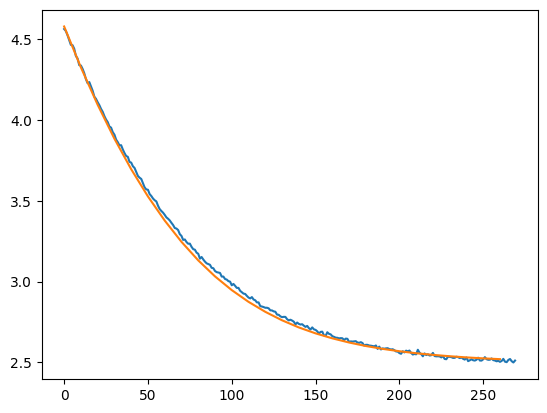

In [386]:
plot_dim = len(vlossi) * 10
from matplotlib import pyplot as plt
plt.plot(lossi[:plot_dim * (lossi.numel() // plot_dim)].view((plot_dim, -1)).mean(1))
plt.plot([i * 10 for i in range(len(vlossi))], vlossi)

# MLP Baseline

In [20]:
from torch import nn

In [19]:
# input
# embedding layer
# masked multi hjead attention 
# add and norm
# feed forward
# add norm
# linear
# softmax
# probabilities

In [388]:
embedding_dim = hyperparams['embedding_dim']
block_size = hyperparams['block_size']
batch_size = hyperparams['batch_size']
hidden_layer_size = hyperparams['hidden_layer']
epochs = hyperparams['epochs']

In [389]:
model = nn.Sequential(
    nn.Embedding(vocab_size, embedding_dim, device=device),
    nn.Flatten(),
    nn.Linear(embedding_dim * block_size, hidden_layer_size, device=device),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, hidden_layer_size, device=device),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, vocab_size, device=device)
)

for p in model.parameters():
    p.require_grad = True
sum(len(p) for layer in model for p in layer.parameters())

2195

In [390]:
ix = torch.randint(0, X_train.shape[0], (1,))
x, y = X_train[ix], y_train[ix]
x.shape

AttributeError: 'list' object has no attribute 'shape'

In [391]:
x

[[6, 29, 60, 36, 63, 21, 47, 38],
 [12, 6, 29, 35, 21, 59, 59, 3],
 [36, 44, 40, 39, 56, 11, 40, 19],
 [35, 21, 28, 15, 35, 29, 28, 60]]

In [258]:
x = model[0](x)
x.shape

torch.Size([1, 10, 10])

In [262]:
W1 = torch.randn(10, 64, device=device)

In [263]:
x @ W1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x100 and 10x64)

In [246]:
query = nn.Linear(embedding_dim*block_size, attention_size, device=device)
keys = nn.Linear(embedding_dim*block_size, attention_size, device=device)
values = nn.Linear(embedding_dim*block_size, attention_size, device=device)

In [247]:
q = query(x)
k = keys(x)

In [252]:
(q @ k.T).shape

torch.Size([1024, 1024])

In [228]:
lossi, vlossi = [], []

for i in range(30000):
    # forward pass
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    x, y = X_train[ix], y_train[ix]
    x = model(x)
    loss = nn.functional.cross_entropy(x, y)
    

    for p in model.parameters():
        p.grad = None

    # backward pass
    loss.backward()
    
    lr = 0.1 if i < 15000 else 0.01
    for p in model.parameters():
        p.data -= lr * p.grad
        
    lossi.append(loss.item())
    if i % 250 == 0:
        with torch.no_grad():
            # validation loss
            logits_val = model(X_val)
            loss_val = nn.functional.cross_entropy(logits_val, y_val)
            vlossi.append(loss_val.item())
            
            if i % 1000 == 0:
                print(f"{i}: train loss = {loss.item():.2f}, validation loss = {loss_val.item():2f}")

0: train loss = 4.185055732727051, validation loss = 4.141956329345703
1000: train loss = 2.377685070037842, validation loss = 2.4429502487182617
2000: train loss = 2.231973171234131, validation loss = 2.2896788120269775
3000: train loss = 2.082155704498291, validation loss = 2.1420059204101562
4000: train loss = 1.9366093873977661, validation loss = 2.022430181503296
5000: train loss = 1.8920868635177612, validation loss = 1.9656044244766235
6000: train loss = 1.784192442893982, validation loss = 1.9314466714859009
7000: train loss = 1.760754108428955, validation loss = 1.8996379375457764
8000: train loss = 1.674952507019043, validation loss = 1.8834093809127808
9000: train loss = 1.6659841537475586, validation loss = 1.8579070568084717
10000: train loss = 1.6491072177886963, validation loss = 1.8419277667999268
11000: train loss = 1.611682415008545, validation loss = 1.8020172119140625
12000: train loss = 1.560142159461975, validation loss = 1.7966078519821167
13000: train loss = 1.6

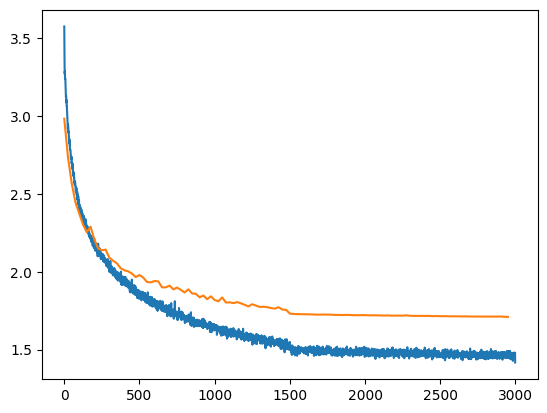

In [229]:
from matplotlib import pyplot as plt
plt.plot(torch.tensor(lossi).view(-1, 10).mean(1)[1:])
plt.plot([25*x for x in range(len(vlossi[1:]))], vlossi[1:])